<a href="https://colab.research.google.com/github/janchorowski/JSALT2019_tutorials/blob/master/vae_nanxin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variatoinal Auto-Encoder Lab Session

The following exercises will make you familiar with the Variational Autoencoder, or VAE for short. For the details consult the paper:

[Kingma and Welling, Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

Try not to spend too much time on a single task; if you find yourself stuck, ask for help!

**Make sure to set `Runtime->Change runtime type` to Python 3 and GPU.**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
%matplotlib inline

In [0]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

Downloading...
From: https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR
To: /content/cifar.npz
185MB [00:01, 165MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
55.4MB [00:00, 77.5MB/s]


In [0]:
import os
import re

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat
        
sns.set_style('whitegrid')

def n(t):
    return t.detach().cpu().numpy()

# The variational autoencoder (VAE, [Kingma 2014](https://arxiv.org/abs/1312.6114))

The VAE is a latent variable model able to learn difficult probability distributions, such as generating MNIST images. 

We will assume that data samples are generated in a two step process:
1. Sample a latent code $z$ from prior $p_\theta(z)$, such as a multivariate standard normal.
2. Sample $x$ from $p_\theta(x|z) = \mathcal{B}(\mu=d_\theta(z))$  and $d_\theta(z)$ is a complicated, learned transformation function typically implemented using a neural network.

In other words, the VAE generates samples from a complicated distribution $p_\theta(x)=p_\theta(x|z)p_\theta(z)$ by sampling from a simple probability distribution, followed by a highly nonlinear transformation.

This is a framework for a powerful deep generative model that can map a distribution of complex data points such as images to a simpler distribution (the prior) from which you can then sample and decode back into the original distribution of the data points.

During training, the model learns to encode and decode the data to and from the prior. Then, during inference, you can sample new data points from the prior and create new data points in the data domain.

![VAE](https://docs.google.com/drawings/d/e/2PACX-1vRa9kRQlLV7jYQqnv5kdiJhfMCOPDIElAy_aRSC7oV7AgDuwfLimec92GDkZxcotvEIc9wziAlgV8If/pub?w=960&h=720)

## Technicalities

An autoencoder would map the data points to latent codes, but they 1) wouldn't be tied to a unit gaussian, and 2) wouldn't guarantee a good coverage of the prior space. How do we enforce that? The solution proposed by the VAE is to treat each data point as a random variable, represented not by a a latent code, but by a latent distribution. Concretely, encoding an input image would not give back a latent code $z$ but a pair of $\mu s$ and $\sigma s$ that we can consider as a gaussian distribution $\mathcal{N}(\mu, \sigma^2)$ from which to sample the latent. You can also interpret it as a pair of a latent and a noise amplitude, and we use the disturbed latent as input to the decoder.

Then we train the VAE with two competing losses:
- The reconstruction loss aims to reconstruct the input sample as well as possible. For this, very distant and not noisy latents are preferable
- The prior loss aims to make each latent code fit the prior as close as possible, that is, latents close to the origin and coverage of the latent space fitting the prior (big noise amplitude / $\sigma = 1$). This is represented by the KL divergence between the prior and latent distributions.

If everything goes well, your latent space will look like the picture on top of this notebook.

If you prefer real maths to handwavy explanation, see the demonstration and derivation at the end of this notebook :)


For now let's just demonstrate a mapping from gaussiant to ring distribution

Text(0.5, 1.0, 'x = d(z)')

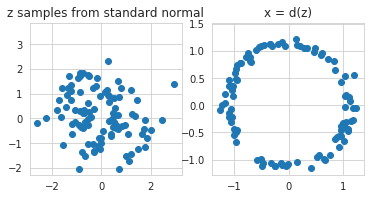

In [0]:
z = np.random.randn(2,100)  # z is standard normal

def d(z):
    return z/10 + z/np.linalg.norm(z, axis=0, keepdims=True)

x = d(z)

plt.subplot(121)
plt.scatter(z[0,:], z[1,:])
plt.axis('square')
plt.title('z samples from standard normal')

plt.subplot(122)
plt.scatter(x[0,:], x[1,:])
plt.axis('square')
plt.title('x = d(z)')

# Coding the VAE

## Loading the data

Let's load MNIST, and create a data loader that keeps everything into memory to have a faster training

In [0]:
with np.load('mnist.npz') as data:
    mnist_full_train_data = data['train_data'].astype('float32') / 255.0
    mnist_full_train_labels = data['train_labels']
    mnist_test_data = data['test_data'].astype('float32') / 255.0
    mnist_test_labels = data['test_labels']

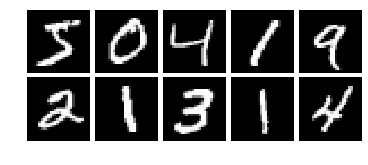

In [0]:
plot_mat(mnist_full_train_data[:10, None], cmap='gray')

In [0]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

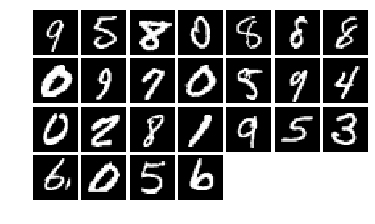

In [0]:
train_loader = InMemDataLoader(
    (mnist_full_train_data, ), batch_size=25, shuffle=True)
test_loader = InMemDataLoader(
    (mnist_test_data, ), batch_size=100, shuffle=False)

batch_x, = next(iter(train_loader))
plot_mat(batch_x.numpy()[:,None,:,:], cmap='gray')

## Coding the VAE

Here comes the definition of the model. We have done the hyper parameters search for you and here is the architecture we propose you to write:

- Encoder:
  - Fully Connected 1 * 28 * 28 -> 500
  - ReLU
  - Fully Connected 500 -> 500
  - ReLU
  - Fully Connected 500 -> 40

- Sampler:
  - Since we have a dimension of 40 as encoder output, that means 20 gaussians. First 20 are $\mu$ and next 20 are $s=\log(\sigma^2)$.
  - To sample from this distribution, we will use the reparametrization trick. $$\mathcal{N}(\mu, \sigma^2) = \exp(\frac{1}{2}s) * \mathcal{N}(0, 1) + \mu$$ That results in a latent of dimension 20.
  
- Decoder:
  - Fully Connected 20 -> 500
  - ReLU
  - Fully Connected 500 -> 500
  - ReLU
  - Fully Connected 500 -> 1 * 28 * 28
  - Sigmoid
  
- Losses:
  - reconstruction: BCE(reconstruction, original)
  - KL: $\frac{1}{2}\sum 1 + s - \mu^2 - \exp(s)$

In [0]:
# Hyperparams

inp_dim = batch_x.shape[1:]
enc_dim = 500
latent_dim = 2

class Encoder(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(np.prod(inp_dim), enc_dim)
        self.fc2 = nn.Linear(enc_dim, enc_dim)
        #
        # TODO: Fill in the missing code
        #
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #
        # TODO: Fill in the missing code
        #

class Decoder(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, enc_dim)
        self.fc2 = nn.Linear(enc_dim, enc_dim)
        self.fc3 = nn.Linear(enc_dim, np.prod(inp_dim))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #
        # TODO: Fill in the missing code
        #

class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #FIXME: write self.encoder and self.decoder
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def reparameterize(self, z_mean, z_log_sigma2):
        #
        # TODO: Fill in the missing code
        #
    
    def forward(self, x):
        z_mean, z_log_sigma2 = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_sigma2)
        reconstruction = self.decoder(z).view(x.size())
        return reconstruction, z_mean, z_log_sigma2
        
def elbo_loss(x, reconstruction, z_mean, z_log_sigma2, beta=1.0):
    # FIXME: write losses
    N = x.size(0)
    rec_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum') / N
    #
    # TODO: Fill in the missing code
    #
    return (rec_loss + beta * KL_loss,
            {'rec_loss': rec_loss.item(), 'KL_loss': KL_loss.item()})


In [0]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1.0e-5)
global_step = 0

## VAE training dynamics

In the cell below we train the VAE.

Please note, that while the global loss is decreasing (upper bound on the negative log likelihood is getting smaller), the two terms that make the loss have a more complicated dynamics. At the beginning, the KL term is close to zero, meaning that the VAE carries no information about $x$ through the latent code $z$. Then, the KL term increases ($z$ begin to encode information about $x$). This causes a drastic reduction of the reconstruction loss, which results on an overall decline of the total loss.



In [0]:
model.train()

model.to('cuda')
train_loader.to('cuda')

for epoch in range(20):
    for inum, (batch_x, ) in enumerate(train_loader):
        global_step += 1
        optimizer.zero_grad()
        reconstruction, mu, sigma2 = model(batch_x)
        loss, stats = elbo_loss(batch_x, reconstruction, mu, sigma2, beta=1.0)
        loss.backward()
        optimizer.step()
        if (global_step%1000) == 1:
            print("global step: %d (epoch: %d, step: %d), loss: %f %s" % 
                  (global_step, epoch, inum, loss.item(), stats))

global step: 1 (epoch: 0, step: 0), loss: 545.413818 {'rec_loss': 545.412841796875, 'KL_loss': 0.0009691178565844893}
global step: 1001 (epoch: 0, step: 1000), loss: 182.136597 {'rec_loss': 178.39126586914062, 'KL_loss': 3.7453277111053467}
global step: 2001 (epoch: 0, step: 2000), loss: 192.214325 {'rec_loss': 187.68673706054688, 'KL_loss': 4.52759313583374}
global step: 3001 (epoch: 1, step: 600), loss: 164.477875 {'rec_loss': 159.89404296875, 'KL_loss': 4.583832740783691}
global step: 4001 (epoch: 1, step: 1600), loss: 153.175690 {'rec_loss': 148.5216522216797, 'KL_loss': 4.654045104980469}
global step: 5001 (epoch: 2, step: 200), loss: 171.211548 {'rec_loss': 166.60354614257812, 'KL_loss': 4.608002662658691}
global step: 6001 (epoch: 2, step: 1200), loss: 159.151703 {'rec_loss': 153.79739379882812, 'KL_loss': 5.354305267333984}
global step: 7001 (epoch: 2, step: 2200), loss: 185.131699 {'rec_loss': 180.4700927734375, 'KL_loss': 4.6616106033325195}
global step: 8001 (epoch: 3, step:

## VAE analysis

Now that your VAE trained, we will build your intuitive understanding of it buy running some experiments.

### The AE in VAE

A VAE is first and foremost an AutoEncoder, so let's see how reconstructions go.

You should:
1. Use $\mu$ as the latent code and use your VAE as a deterministic AE.
2. Sample from the VAE and decode the same data point multiple times.

What are the differences? Why?

Text(0.5, 1.0, 'Reconstructions from multiple latent samples')

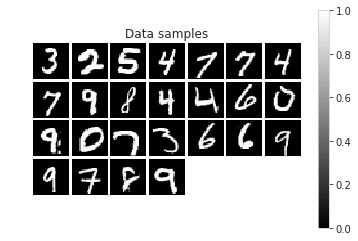

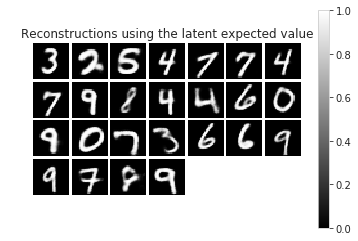

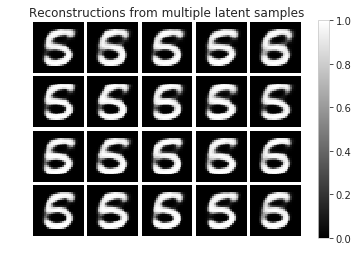

In [0]:
# In this cell we look at the VAE from the autoencoder perspective.
# We see how well it can reconstruct the input data and,
# given its probablilistic nature, how variable are the reconstructions
# when several zs are samples from q(z|x).
#


model.eval()
batch_x = next(iter(train_loader))[0]
with torch.no_grad():
    reconstruction, mu, sigma2 = model(batch_x)


plot_mat(n(batch_x)[:,None,:,:], cmap='gray')
plt.colorbar()
plt.title('Data samples')


reconstruction_from_mean = model.decoder(mu).view(batch_x.size())
plt.figure()
plot_mat(n(reconstruction_from_mean)[:, None, :, :], cmap='gray')
plt.colorbar()
plt.title('Reconstructions using the latent expected value')

same_x = batch_x[2:3].repeat(20, 1, 1)
same_recs, _, _ = model(same_x)
plt.figure()
plot_mat(n(same_recs)[:, None, :, :], cmap='gray')
plt.colorbar()
plt.title('Reconstructions from multiple latent samples')

### Interpolation in latent space

The whole point of a VAE is to contract the latent space in a unit gaussian space and hope that this whole latent space can be decoded meaningfully. In this regard, we will interpolate between two data points, ie, walk from one to the other and watch the data points in between.

With two data points $x_1, x_2$ and their encoded representations $\mu_1, s_1 = \text{Enc}(x_1)$ and $\mu_2, s_2 = \text{Enc}(x_2)$, you will sample intermediate data points $\text{Dec}(\sigma_i z + \mu_i), z \sim \mathcal{N}(0, 1)$ from intermediate latents $\mu_i, \sigma_i$ using
- $\mu_i = t\mu_2 + (1 - t)\mu_1$
- $\sigma_i = t\sigma_2 + (1 - t)\sigma_1$
- with $t$ going from 0 to 1 by taking N intermediate values. You can use `torch.linspace(0, 1, N)`

Text(0.5, 1.0, 'interpolation between two samples')

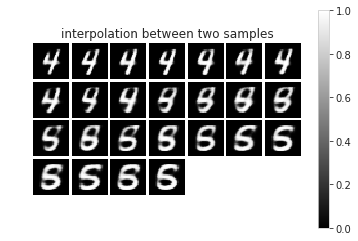

In [0]:
# Here we make an interpolation in the latent space: we take two samples and 
# find their latent codes. We then connect the codes using a straigth line,
# and plot reconstruction as we moove through this line.

#FIXME:
# get t
# interpolate mu and sigma
# decode mu_i and sigma_i
# show the resulting images

interp_weights = torch.linspace(
    0.0, 1.0, steps=25, dtype=torch.float32, device=batch_x.device).view(-1, 1)
k1, k2 = 2, 3
interp_mu = interp_weights * mu[k1] + (1.0 - interp_weights) * mu[k2]
interp_sigma2 = interp_weights * sigma2[k1] + (1.0 - interp_weights) * sigma2[k2]
interp_recs = model.decoder(
    model.reparameterize(interp_mu, interp_sigma2)).view(-1, 1, 28, 28)

plt.figure()
plot_mat(n(interp_recs), cmap='gray')
plt.colorbar()
plt.title('interpolation between two samples')

### VAE as a generative model

Let's fully exploit the latent space without relying on any datapoint, and show $\text{Dec}(z), z \sim \mathcal{N}(0, 1)$

Text(0.5, 1.0, 'Samples from a 20dimensional VAE')

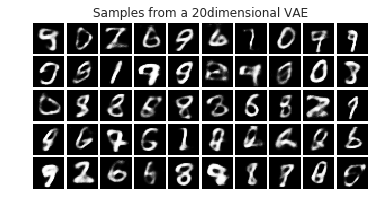

In [0]:
z_rand = torch.randn(50, latent_dim, device=batch_x.device, dtype=batch_x.dtype)
samples = model.decoder(z_rand).view(-1, 1, batch_x.size(1), batch_x.size(2))
plot_mat(n(samples), cmap='gray')
plt.title("Samples from a %ddimensional VAE" % latent_dim)

### Exploring the latent space

We can train a VAE with a 2D latent space, and evenly sample the latents on a grid to see how the VAE mapped and grouped the data samples.

Go back to the cell training the VAE, but use a latent dim of 2.

In order to create a list of coordinates covering a space from -3 to 3 in both x and y, you can use
```python
mesh_x, mesh_y = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
coords = np.concatenate([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)], axis=1)
```

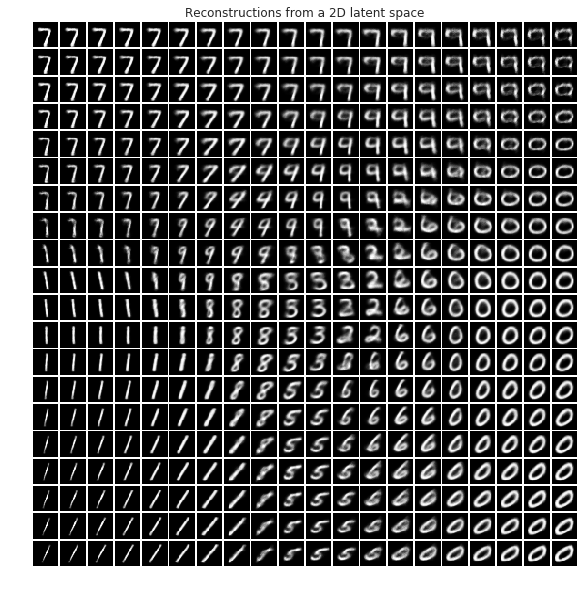

In [0]:
# Finally, for a 2D latent space, we can draw images that are generated from 
# a grid over the two latent dimensions.
#

if latent_dim == 2:
    plt.figure(figsize=(10, 10))
    z_mesh_x, z_mesh_y = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
    z_mesh = np.concatenate([z_mesh_x.reshape(-1, 1), 
                             z_mesh_y.reshape(-1, 1)], axis=1)

    mesh = model.decoder(torch.tensor(z_mesh, dtype=torch.float32, device=batch_x.device)).view(-1, 1, 28, 28)
    plot_mat(n(mesh), prop=(1,1), cmap='gray')
    plt.title('Reconstructions from a 2D latent space')

### Data points as distributions

Since each data point is mapped to a distribution, let's visualize it. The ellipses represent the standard deviation of each data point.

- What do you see?
- Is the KL effective at grouping datapoint in the unit gaussian space?
- Why are the std dev bigger on the periphery than in the middle?
- What would happen if you fixed the std dev instead of allowing the encoder to learn it?
- Compare this plot with the grid above this cell, can you observe a difference in samples between where the data points are, and where the holes are?

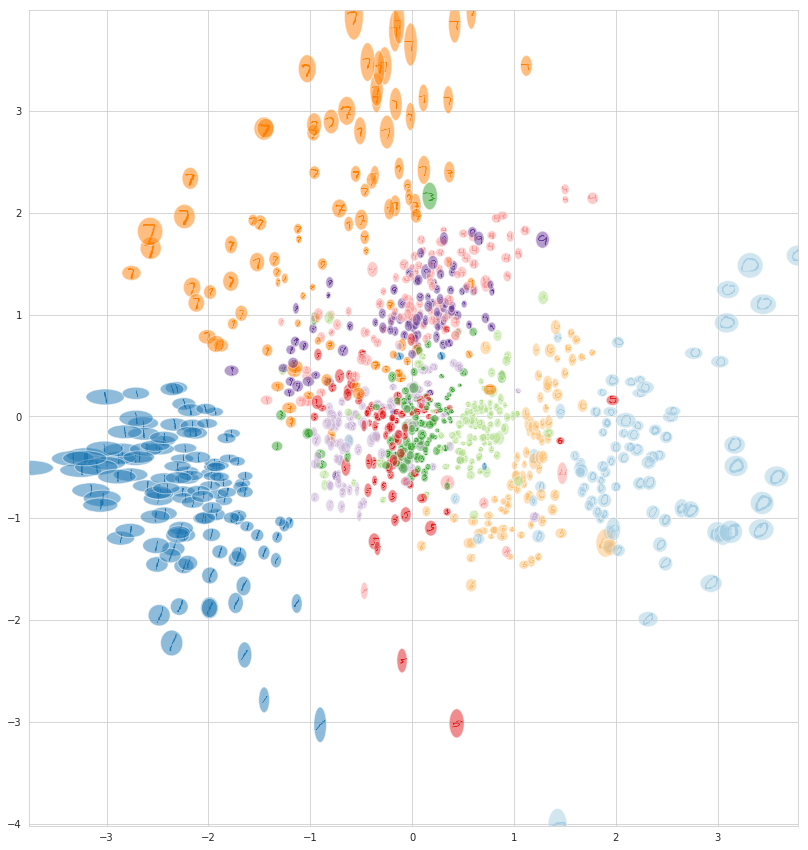

In [0]:
import matplotlib

def viz_distribs(model, mnist):
    def make_ellipse(mean, std, ax, **kwargs):
        """Plot an ellipse."""
        kwargs.setdefault('alpha', 0.5)
        ell = matplotlib.patches.Ellipse(mean, std[0], std[1], **kwargs)
        ell.set_clip_box(ax.bbox)
        ax.add_artist(ell)

    colors = np.array([
        [166,206,227],
        [31,120,180],
        [178,223,138],
        [51,160,44],
        [251,154,153],
        [227,26,28],
        [253,191,111],
        [255,127,0],
        [202,178,214],
        [106,61,154],
    ]) / 255.0

    colors_init = np.hstack((colors, np.zeros((colors.shape[0], 1))))
    colors_full = np.hstack((colors, np.ones((colors.shape[0], 1))))

    cmaps = [matplotlib.colors.LinearSegmentedColormap.from_list("S0", [colors_init[i], colors_full[i]])
             for i in range(colors.shape[0])]

    plt.figure(figsize=(15, 15))
    ax = plt.gca()
    z_mean, z_log_sigma2 = model.encoder(torch.from_numpy(mnist[:1000]).cuda())
    z_mean = z_mean.detach().cpu().numpy()
    z_mean[:, 1] *= -1 # workaround matplotlib's negative axis
    z_sigma = z_log_sigma2.exp().sqrt().detach().cpu().numpy()
    for i, (z_mean_i, z_sigma_i)  in enumerate(zip(z_mean, z_sigma)):
        x, y = z_mean_i
        sx, sy = z_sigma_i
        s = min(sx, sy)
        ax.imshow(mnist_test_data[i], cmap=cmaps[mnist_test_labels[i]],
                  extent=[x - s, x + s, y - s, y + s])
        make_ellipse(z_mean_i, z_sigma_i * 2, ax,
                     facecolor=colors[mnist_test_labels[i]])

    plt.xlim(z_mean[:,0].min(), z_mean[:,0].max())
    plt.ylim(z_mean[:,1].min(), z_mean[:,1].max())

viz_distribs(model, mnist_test_data)

# Drivation of ELBO, the VAE training objective.

The VAE is a generative model which samples new data in a two-step process:
1. $z \sim p_\Theta(z)$
2. $x \sim p_\Theta(x|z)$

For training and inference we are ointerested in the following two distributions induced by the above model:

1. $p_\Theta(x) = \int dz p_\Theta(x|z)p_\Theta(z)$
2. $p_\Theta(z|x) = \frac{p_\Theta(x|z)p_\Theta(z)}{p_\Theta(x)} = \frac{p_\Theta(x|z)p_\Theta(z)}{\int dz p_\Theta(x|z)p_\Theta(z)}$

However, these are often impossible to compute.

## A log-likelihood lower bound

To derive a trainig objective for the VAE we will introduce an approximate distribution $q_\phi(z|x)$ that is easy to compute, but may not be accurate. In fact, $q_\phi(z|x)$ is often parameterized as another neural computation, which returns both the mean and standard deviation of a normal distribution:   $q_\phi(z|x) = \mathcal{N}([\mu, \sigma] =e_\phi(x))$.

We will derive a similar bound for the log-likelihood as we did in the EM case:

\begin{equation}
\begin{split}
KL(q_\phi(z|x) || p_\theta(z|x)) &= \mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z|x)}{q_\phi(z|x)}\right]= \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z|x)p_\theta(x)}{q_\phi(z|x)p_\theta(x)}\right]= \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z|x)p_\theta(x)}{q_\phi(z|x)}\right] + \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x)\right] = \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(x,z)}{q_\phi(z|x)}\right] +\log p_\theta(x) 
\end{split}
\end{equation}

Thus
$$
\log p_\theta(x)  = KL(q_\phi(z|x) || p_\theta(z|x)) + \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log\frac{p_\theta(x,z)}{q_\phi(z|x)}\right].
$$

Since $KL(\cdot||\cdot)\geq 0$, we get
\begin{equation}
\begin{split}
\log p_\theta(x)  &\geq \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log\frac{p_\theta(x,z)}{q_\phi(z|x)}\right] = \\
&= \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log\frac{p_\theta(x|z)p_\theta(z)}{q_\phi(z|x)}\right] = \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - \mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z)}{q_\phi(z|x)}\right] \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - KL(q_\phi(z|x) || p_\theta(z))
\end{split}
\end{equation}

We call this form the Evidence Lower Bound (ELBO), because for any $q(z|x)$ it gives us a lower bound on the log-likelihood of a data sample.

The two terms of ELBO have an intuitive meaning:
1. $\mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x|z)\right] = \int_z q_\phi(z|x) p_\theta(x|z) dz$ is the log-likelihood of samples generated in a two-step process in which we first zample a $z$ from the approximating distribution $q$, then sample $x$.
2. $- KL(q_\phi(z|x) || p_\theta(z))$ gives the mismatch between the approximatio $q_\phi(z|x)$ and the prior $p_\theta(z)$. The larger the divergence, the more information about $x$ we encode in the $q$ distribution. 

Intuitively, the ELBO is large when we:
1. properly reconstruct $x$
2. transferring the minimal amount of information in $q\phi(z|x)$.

## Optimizing the ELBO
Im machine learning we are used to minimizing loss fnuctions. The negation of the ELBO gives us:
$$
-\log p_\theta(x) \leq \mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log p_\theta(x|z)\right] + KL(q_\phi(z|x) || p_\theta(z))
$$
which states that our training objective is to minimize the negative log-likelihood of the reconstructed data (reconstruction loss), augmented with a penalty on the latent code expressed as the KL from a simple prior distribution. The more specific the approximate posterior $q_\phi(z|x)$, the more penalty the model pays.

We will train our model by minimizing this upper bound on the negative log likelihood using gradient methods. For a Gaussian prior $p_\theta(z)$ and Gaussian approximate posterior $q_\phi(z|x)$ the KL-term can be computed and differentiated analytically.

Computing gradients of the reconstruction loss is more involved. We will first replace the expected value with a Monte Carlo estimation that uses $m$ samples:

$$
\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log p_\theta(x|z)\right] \approx 
\frac{1}{m}\sum_{i=1}^m -\log p_\theta(x|z_i),\qquad\text{where } z_i \sim q_\phi(z|x).
$$

This is however not enough, because we will want to optimize the approximating distribution $q$ over its parameters $\phi$, however we can't differentiate through the sampling operation.

We will therefore introduce a reparameterization: instead of sampling from $q_\phi(z|x) = \mathcal{N}([\mu, \sigma] =e_\phi(x))$ we will sample from a standard normal, then shift and scale by the parameters given by e_\phi(x).

Let $[\mu, \sigma] =e_\phi(x)$. Then
$$
\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log p_\theta(x|z)\right] \approx 
\frac{1}{m}\sum_{i=1}^m -\log p_\theta(x|z=\epsilon_i \cdot \sigma + \mu),\qquad\text{where } \epsilon_i \sim \mathcal{N}(0,1).
$$

Finally, this form allows to backpropagate the loss gradient to the parameters of $q$, i.e. to the $e_\phi()$ neural network.

## VAE as an autoencoder

The VAE involves two neural networks:
1. The $e_\phi()$ specifies the parameters of a distribution onver the latents, $z$, given a data sample $x$. It thus acts as an encoder
2. Conversely, $d_\theta()$ reconstructs $x$ based on a sample $z$. Thus it acts as a decoder. 

Thus the VAE can be seen as a probabilitisc autoencoder, which assigns, for each data sample, a probability distribution over latents. Reconstructions are probabilistic, too -- we can sample several reconstructions of a single data sample.

Training the VAE optimizes the ELBO criterion, composed of two terms: the first wants to make good reconstructions, this is similar to other autoencoders. The second term penalizes the amount of information that the VAE carries about the data sample in its latent code. Thus it can be seen as an information-bottleneck auoencoder in which, instead of enforcing latent code dimensionality or sparsity, we limit the amount of information that it carries.

However, unlike regilar autoencoders the VAE is aprobabilistic model, which allows generatin new data points. To do so, We only need to know the assumed prior distribution $p_\theta(z)$ and the trained decoder $p_\theta(x|z)$.